In [1]:
# import modified visualpriors library
from transforms import VisualPriorRepresentation, VisualPriorPredictedLabel
from taskonomy_network import TaskonomyEncoder, TaskonomyDecoder

import torchsummary
from PIL import Image
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

import torchvision.transforms.functional as TF
import torch.utils.model_zoo # required to load nets

import classes

%load_ext autoreload
%autoreload 2

# Load Taskonomy Network

In [2]:
task = 'autoencoding'

VisualPriorRepresentation._load_unloaded_nets([task]) # preload nets
net = VisualPriorRepresentation.feature_task_to_net[task] # loads encoder only for representations

In [3]:
torchsummary.summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# Create tweaked net for retrieving activations

In [4]:
train_nodes, eval_nodes = get_graph_node_names(net)
print(len(eval_nodes))
eval_nodes


180


['x',
 'pad',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.relu_1',
 'layer1.0.conv3',
 'layer1.0.bn3',
 'layer1.0.downsample.0',
 'layer1.0.downsample.1',
 'layer1.0.add',
 'layer1.0.relu_2',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.relu_1',
 'layer1.1.conv3',
 'layer1.1.bn3',
 'layer1.1.add',
 'layer1.1.relu_2',
 'layer1.2.conv1',
 'layer1.2.bn1',
 'layer1.2.relu',
 'layer1.2.conv2',
 'layer1.2.bn2',
 'layer1.2.relu_1',
 'layer1.2.conv3',
 'layer1.2.bn3',
 'layer1.2.downsample.0',
 'layer1.2.add',
 'layer1.2.relu_2',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.relu_1',
 'layer2.0.conv3',
 'layer2.0.bn3',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.0.add',
 'layer2.0.relu_2',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.b

In [5]:
return_nodes = { k:k for k in ['conv1']+[node for node in eval_nodes if "conv3" in node]}

In [6]:
net_tweaked = create_feature_extractor(net, return_nodes=return_nodes)
net_tweaked

TaskonomyEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Module(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

# Load Image, convert to tensor, create image parts

In [ ]:
def checkerboard(scale, output_size=640):
    board = np.indices((scale,scale)).sum(axis=0) % 2
    board = board.repeat(output_size/scale,axis=0).repeat(output_size/scale, axis=1)
    board = board[:,:, np.newaxis,].repeat(3,axis=2)
    return board.astype(dtype = np.bool_)

In [297]:
img = Image.open('./data/stimuli_places1/Places365_val_00036011.jpg')
img = img.resize((640,640))




(torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]))

tensor([[[[-0.4528, -0.3664, -0.8162,  ..., -0.2961,  0.5057, -0.6859],
          [-0.5803, -0.8162, -0.4729,  ..., -0.7846, -0.8162,  0.3603],
          [-0.7542, -0.8162,  0.2216,  ..., -0.8162, -0.4877, -0.3013],
          ...,
          [-0.8162, -0.8162, -0.6959,  ...,  0.0985,  0.0986, -0.1222],
          [-0.8162, -0.8162, -0.8162,  ..., -0.4261, -0.3801, -0.4778],
          [-0.8162, -0.8162, -0.8162,  ..., -0.6613, -0.7018, -0.6453]],

         [[-1.3832, -0.2445,  0.2892,  ..., -0.3891,  0.6618,  2.5566],
          [ 0.5228,  0.4793,  1.4076,  ...,  0.0806, -0.1539, -0.4088],
          [-0.6595,  0.4026,  0.5568,  ...,  0.0831,  0.6688,  1.1236],
          ...,
          [-0.4515, -0.8841, -0.8970,  ..., -1.1779, -0.9259, -1.0805],
          [-0.7847, -0.6151, -0.9764,  ..., -0.6492, -0.9287, -0.9249],
          [-0.8928, -1.0541, -0.8814,  ...,  0.8187,  0.7076,  0.7199]],

         [[-1.1164, -0.6823, -0.2015,  ..., -0.3647,  0.1161, -0.6238],
          [ 0.4406, -1.1164,  

In [ ]:
img = np.array(img)

img1, img2 = np.where(checkerboard(4), img, 255), np.where(~checkerboard(4), img, 255)

img, img1, img2 = Image.fromarray(img), Image.fromarray(img1), Image.fromarray(img2)
img, img1, img2 = TF.to_tensor(TF.resize(img, 256)) * 2 - 1, TF.to_tensor(TF.resize(img1, 256)) * 2 - 1, TF.to_tensor(TF.resize(img2, 256)) * 2 - 1
img, img1, img2 = img.unsqueeze_(0), img1.unsqueeze_(0), img2.unsqueeze_(0)
img.shape, img1.shape, img2.shape

# Get activations for image and image parts

In [302]:
img_act = net_tweaked(img)
img1_act = net_tweaked(img1)
img2_act = net_tweaked(img2)

# Calculate average activation for image parts

In [328]:
img12avg_act = { k:None for k in img_act.keys()}
img12avg_act.keys()

dict_keys(['conv1', 'layer1.0.conv3', 'layer1.1.conv3', 'layer1.2.conv3', 'layer2.0.conv3', 'layer2.1.conv3', 'layer2.2.conv3', 'layer2.3.conv3', 'layer3.0.conv3', 'layer3.1.conv3', 'layer3.2.conv3', 'layer3.3.conv3', 'layer3.4.conv3', 'layer3.5.conv3', 'layer4.0.conv3', 'layer4.1.conv3', 'layer4.2.conv3'])

In [329]:
for layer in img_act.keys():
    img12avg_act[layer] = torch.stack((img1_act[layer], img2_act[layer]), dim=0).mean(dim=0)

In [333]:
print("Sanity check on average partial and full activations")
for layer in img_act.keys():
    print(img_act[layer].shape == img12avg_act[layer].shape)

Sanity check on average partial and full activations
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Integration coeficient

In [342]:
integration = { k:None for k in img_act.keys()}

for (layer_name, a1, a2) in zip(integration.keys(), img_act.values(), img12avg_act.values()):
    integration[layer_name] = pearsonr(a1.flatten(), a2.flatten())[0]

In [343]:
integration

{'conv1': 0.40729756716665555,
 'layer1.0.conv3': 0.6745515510880234,
 'layer1.1.conv3': 0.6868518200708082,
 'layer1.2.conv3': 0.556130370234268,
 'layer2.0.conv3': 0.4720182796488609,
 'layer2.1.conv3': 0.6269456240391732,
 'layer2.2.conv3': 0.5816056757982644,
 'layer2.3.conv3': 0.6739314131008236,
 'layer3.0.conv3': 0.4680791699987305,
 'layer3.1.conv3': 0.5595264355634131,
 'layer3.2.conv3': 0.46011123919078367,
 'layer3.3.conv3': 0.8646102608616395,
 'layer3.4.conv3': 0.8408697116079211,
 'layer3.5.conv3': 0.8424194566429843,
 'layer4.0.conv3': 0.4930085014707125,
 'layer4.1.conv3': 0.5437964458902835,
 'layer4.2.conv3': 0.7685934590125757}

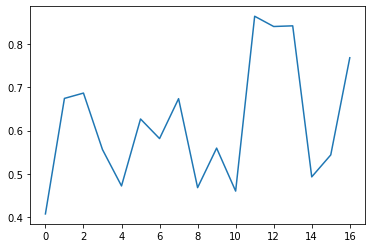

In [349]:
plt.plot(list(integration.values()))

# Read beauty ratings


In [355]:
pd.read_csv('~/Documents/Thesis/Taskonomy Integration/behavior/ratings_study1.csv', header=None).mean(axis=1)

0      86.00
1      70.76
2      33.68
3      35.84
4      40.72
       ...  
245    60.76
246    38.52
247    65.24
248    56.44
249    62.48
Length: 250, dtype: float64

In [367]:
img_dir = '/home/max/Documents/Thesis/Taskonomy Integration/data/stimuli_places1'
l = list(f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f)) and f.endswith('.jpg'))
l.sort()
l

['Places365_val_00001153.jpg',
 'Places365_val_00001154.jpg',
 'Places365_val_00001159.jpg',
 'Places365_val_00001199.jpg',
 'Places365_val_00001200.jpg',
 'Places365_val_00001218.jpg',
 'Places365_val_00001221.jpg',
 'Places365_val_00001223.jpg',
 'Places365_val_00001225.jpg',
 'Places365_val_00001228.jpg',
 'Places365_val_00001236.jpg',
 'Places365_val_00001238.jpg',
 'Places365_val_00001240.jpg',
 'Places365_val_00001241.jpg',
 'Places365_val_00001248.jpg',
 'Places365_val_00001253.jpg',
 'Places365_val_00001265.jpg',
 'Places365_val_00001268.jpg',
 'Places365_val_00001271.jpg',
 'Places365_val_00001274.jpg',
 'Places365_val_00001279.jpg',
 'Places365_val_00001285.jpg',
 'Places365_val_00001286.jpg',
 'Places365_val_00001289.jpg',
 'Places365_val_00001290.jpg',
 'Places365_val_00001295.jpg',
 'Places365_val_00001296.jpg',
 'Places365_val_00001297.jpg',
 'Places365_val_00001298.jpg',
 'Places365_val_00001303.jpg',
 'Places365_val_00001310.jpg',
 'Places365_val_00001314.jpg',
 'Places

In [9]:
pl_dataset= classes.ImageDataset('/home/max/Documents/Thesis/Taskonomy Integration/data/stimuli_places1')
pl_it = iter(pl_dataset)

# Correlate integration with beauty

In [7]:
inc = classes.IntegrationCalculator(net, return_nodes)

In [28]:
pl_dataset= classes.ImageDataset('/home/max/Documents/Thesis/Taskonomy Integration/data/stimuli_places1')
pl_it = iter(pl_dataset)

In [85]:
l = []
for idx, img in enumerate(pl_dataset):
    l.append(inc.integration_coeff(img))
    if idx == 10:
        break

res = pd.DataFrame(l, columns=inc.evalutation_layers)

In [86]:
ratings = classes.ImageDataset('./data/stimuli_places1', beauty_ratings_path='./behavior/ratings_study1.csv').beauty_ratings[0:11]
ratings

0     86.00
1     70.76
2     33.68
3     35.84
4     40.72
5     28.68
6     41.36
7     55.72
8     36.76
9     50.12
10    90.72
dtype: float64

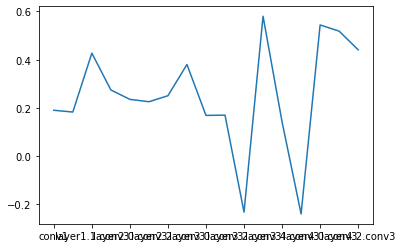

In [98]:
res.aggregate(lambda x: pearsonr(x, ratings)[0], axis= 0).plot()